# Montagem da Rede

In [1]:
import pathlib
import pickle
import cpnet
import netpixi
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from netpixi.integration.gt import *
from regression.integration.gt import *
from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


## Leitura dos Dados Pré-Processados

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'projeto' / 'data'
print(DATA_DIR)

/home/jupyter/notebooks/projeto/data


In [3]:
PROCESSED_FILE_PATH = DATA_DIR / 'processed' / 'enem_sampled.pkl'

In [4]:
print(PROCESSED_FILE_PATH)

/home/jupyter/notebooks/projeto/data/processed/enem_sampled.pkl


In [5]:
with open(PROCESSED_FILE_PATH, 'rb') as file:
    (
        sampled_data
    ) = pickle.load(file)


In [6]:
sampled_data = sampled_data.sample(400)

Resetando os índices para facilitar identificação após montagem da rede

In [7]:
df = sampled_data.reset_index()

In [8]:
print(df.shape)
df.head(5)

(400, 33)


,index,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,Q001,Q002,Q005,Q006,Q007,Q008,...,Gabarito Oficial,Q005_str,Respostas Questionario,Acertos Totias,Questoes Especificas,Questoes Gerais,Gabarito Especificas,Gabarito Gerais,Acertos Gerais,Acertos Especificas
0,963056,210051720667,4,M,G,F,2.0,M,A,E,...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,B,BGFMAEDBABBAABACCC,111,DBBBEDDABADBAECEDBEBBACADDABABDEEEDCBCAAECDCAC...,DEBADCBDACDEEABEACBBDDEBDACCDCDABCDEDBAABCADEB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,44.0,67.0
1,2024270,210053222987,14,F,B,G,3.0,D,A,C,...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,C,CBGDACDAABABABABEA,67,BEEEBAEABEABAEEAEDABBAEEBAEDCAAEBEADBDDEEAABBA...,ECDBECADACBAEABDADEDDDABDABCDBDCABEEEABABEABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,38.0,29.0
2,1719315,210051047791,2,F,E,F,4.0,F,A,B,...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,D,DEFFABCBABBBABADEC,56,DBDEAABDBACBADDADCABAAAAAACBEABEEECBADCABEACAB...,D.DACDBBAADCEACCDDAADBACDABEABCCBCEBAEBCBAAAAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,26.0,30.0
3,313957,210053522123,2,F,H,H,5.0,O,B,E,...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,E,EHHOBEDCABBBBBACEE,68,DCCCEADADECCACDAECABAAEAEBBDCACDBECBACCCEEAEAC...,DCABCDADAABCEABEADBDAAEDDAACCBBCBBEAEAAAEEABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,36.0,32.0
4,277459,210052479163,2,F,H,H,2.0,B,A,B,...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,B,BHHBABBAABAAAAABBA,39,BDAAAACDDCCCDCDBBEADBAABCEADDCCABBDBEEADBBBCEA...,DBECACBAAABAEADCDAADAACCBAEDBBEDCCEDDABCBAABDA...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,21.0,18.0


## Montagem de Rede de Questionário Socioeconômico

In [9]:
n_candidatos = df.shape[0]
n_perguntas_questionario = len(df['Respostas Questionario'].iloc[0])
n_candidatos, n_perguntas_questionario

(400, 18)

In [10]:
respostas_questionario = df['Respostas Questionario'].tolist()

Antes de montar a rede por si só, precisamos dar uma olhada nos dados para ver qual a quantidade de perguntas respondidas em comum para que uma aresta possa ser formada

In [11]:
respostas_iguais_quest = list()
for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_perguntas_questionario):
            if (respostas_questionario[id_prova1][i] == respostas_questionario[id_prova2][i]):
                n_respostas_iguais+=1
        respostas_iguais_quest.append(n_respostas_iguais)

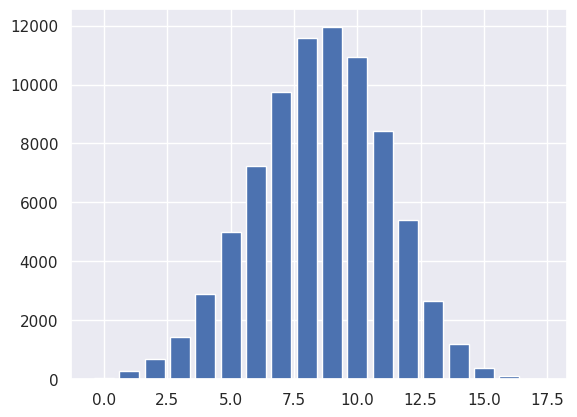

In [12]:
freq_questionario = Counter(respostas_iguais_quest)
plt.figure()
plt.bar(freq_questionario.keys(), freq_questionario.values())
plt.show()

In [13]:
np.mean(respostas_iguais_quest)

8.502606516290728

In [14]:
np.median(respostas_iguais_quest)

9.0

Como esse gráfico se assemelha bastante com uma normal, vamos tentar utilizar a média ~= mediana como threshold de criação de aresta

A máquina disponível começa a travar depois de 50.000 arestas, vamos ver se ela aguenta esse valor

In [15]:
quant_arestas = 0
max_resps_iguais = 0
max_freq_quest = max(freq_questionario)
for i in range(len(freq_questionario)):
    quant_arestas += freq_questionario[n_perguntas_questionario - i]
    if quant_arestas > 50000:
        print(f'Travou em {max_freq_quest - i} com {quant_arestas}')
        max_resps_iguais = max_freq_quest - i
        break

Travou em 7 com 52566


In [16]:
threshold_quest = np.quantile(respostas_iguais_quest, 0.75)
arestas_questionario = list()
for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_perguntas_questionario):
            if (respostas_questionario[id_prova1][i] == respostas_questionario[id_prova2][i]):
                n_respostas_iguais+=1
        if n_respostas_iguais >= threshold_quest:
            arestas_questionario.append((id_prova1, id_prova2))

In [17]:
g_quest = Graph(directed=False)

for aresta in arestas_questionario:
    if not(g_quest.has_vertex(aresta[0])):
        g_quest.add_vertex(aresta[0])
    if not(g_quest.has_vertex(aresta[1])):
        g_quest.add_vertex(aresta[1])
    if not (g_quest.has_edge(aresta[0], aresta[1])):
        g_quest.add_edge(aresta[0], aresta[1])

In [18]:
SAMPLE_400_DIR = pathlib.Path.cwd().parent / 'projeto' / 'sample400'
SAMPLE_400_DIR.mkdir(parents=True, exist_ok=True)

In [19]:
GRAFO_QUESTIONARIO_DIR = SAMPLE_400_DIR / 'quest_socioecon.net.gz'

In [20]:
gt_save(g_quest, GRAFO_QUESTIONARIO_DIR)

In [21]:
n_quest = g_quest.num_vertices()
m_quest = g_quest.num_edges()
max_edges_quest = n_quest * (n_quest - 1) // 2
d_quest = m_quest / max_edges_quest

print(f'Número de vértices: {n_quest}')
print(f'Número de arestas: {m_quest}')
print(f'Número máximo de arestas (gráfico não dirigido): {max_edges_quest}')
print(f'Densidade: {d_quest}')

Número de vértices: 400
Número de arestas: 29015
Número máximo de arestas (gráfico não dirigido): 79800
Densidade: 0.3635964912280702


count    400.000000
mean     145.075000
std       61.563174
min        7.000000
25%      104.750000
50%      160.000000
75%      191.000000
max      258.000000
Name: degree, dtype: float64

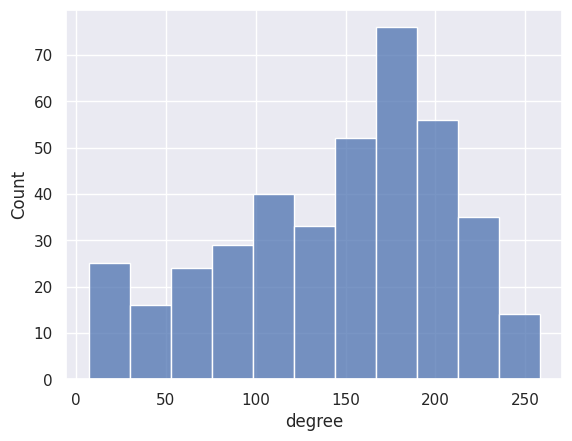

In [22]:
# Função para formatar propriedades dos vértices
data_quest = gt_data(g_quest)

# Soma do in-degree com o out-degree
degrees = []
for v in g_quest.all_vertices():
    degrees.append(v.total_degree())

# Adicionando métricas ao df
data_quest['degree'] = degrees

# Visualizando histograma do degree
sns.histplot(data_quest['degree'])
data_quest['degree'].describe()

In [23]:
GRAFO_QUESTIONARIO_SFPD_DIR = SAMPLE_400_DIR / 'SFDP_quest_socioecon.net.gz'

In [24]:
# Método que aproxima e afasta vértices dependendo se estão ou não conectados, respectivamente
g_quest_SFDP = gt_load(GRAFO_QUESTIONARIO_DIR)
g_quest_SFDP = gt_clean(g_quest_SFDP)
m = gt_draw.sfdp_layout(g_quest_SFDP)
gt_move(g_quest_SFDP, m)
gt_save(g_quest_SFDP, GRAFO_QUESTIONARIO_SFPD_DIR)

In [25]:
GRAFO_QUESTIONARIO_SFPD_DIR

PosixPath('/home/jupyter/notebooks/projeto/sample400/SFDP_quest_socioecon.net.gz')

In [26]:
# r = netpixi.render('./sample400/SFDP_quest_socioecon.net.gz', infinite=True)

Usando coreness para identificar o "quão de centro" é cada vértice

In [27]:
matrix = spectral.adjacency(g_quest_SFDP)

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c_quest = algorithm.get_coreness()

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [28]:
df['c_quest'] = df.index.map(c_quest.get)

In [29]:
# g_quest_SFDP.add_vp('coreness')
# for i, coreness in c_quest.items():
#     v = g_quest_SFDP.get_vertex_by_index(i)
#     v['coreness'] = float(coreness)

# for v in g_quest_SFDP.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

## Montagem da Rede de Conhecimentos Gerais

In [30]:
n_questoes_gerais = len(df['Questoes Gerais'].iloc[0])
n_candidatos, n_questoes_gerais

(400, 71)

In [31]:
questoes_gerais = df['Questoes Gerais'].tolist()

In [32]:
respostas_iguais_prova = list()
for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_questoes_gerais):
            if (questoes_gerais[id_prova1][i] == questoes_gerais[id_prova2][i]):
                n_respostas_iguais+=1
        respostas_iguais_prova.append(n_respostas_iguais)

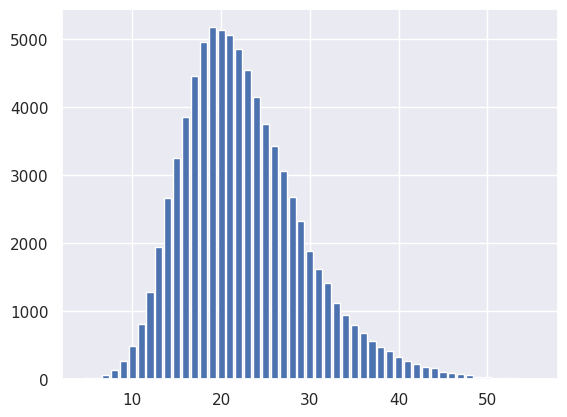

In [33]:
freq_prova = Counter(respostas_iguais_prova)
plt.figure()
plt.bar(freq_prova.keys(), freq_prova.values())
plt.show()

In [34]:
print(f'Média: {np.mean(respostas_iguais_prova)}')
print(f'Mediana: {np.median(respostas_iguais_prova)}')
print(f'Quartis: {np.quantile(respostas_iguais_prova, [0,0.25,0.5,0.75,1])}')

Média: 22.452105263157893
Mediana: 22.0
Quartis: [ 5. 18. 22. 26. 55.]


In [35]:
quant_arestas_geral = 0
threshold = 0
for i in range(len(freq_prova)):
    quant_arestas_geral += freq_prova[max(freq_prova) - i]
    if quant_arestas_geral > 60000:
        print(f'Travou em {max(freq_prova) - i} com {quant_arestas_geral}')
        threshold = max(freq_prova) - i
        break

Travou em 18 com 60577


In [36]:
thresh_prova = np.median(respostas_iguais_prova)
arestas_prova = list()
for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_questoes_gerais):
            if (questoes_gerais[id_prova1][i] == questoes_gerais[id_prova2][i]):
                n_respostas_iguais+=1
        if n_respostas_iguais >= thresh_prova:
            arestas_prova.append((id_prova1, id_prova2))

In [37]:
g_prova = Graph(directed=False)

for aresta in arestas_prova:
    if not(g_prova.has_vertex(aresta[0])):
        g_prova.add_vertex(aresta[0])
    if not(g_prova.has_vertex(aresta[1])):
        g_prova.add_vertex(aresta[1])
    if not (g_prova.has_edge(aresta[0], aresta[1])):
        g_prova.add_edge(aresta[0], aresta[1])

In [38]:
GRAFO_PROVA_DIR = SAMPLE_400_DIR / 'grafo_prova.net.gz'

In [39]:
gt_save(g_prova, GRAFO_PROVA_DIR)

In [40]:
n_prova = g_prova.num_vertices()
m_prova = g_prova.num_edges()
max_edges_prova = n_prova * (n_prova - 1) // 2
d_prova = m_prova / max_edges_prova

print(f'Número de vértices: {n_prova}')
print(f'Número de arestas: {m_prova}')
print(f'Número máximo de arestas (gráfico não dirigido): {max_edges_prova}')
print(f'Densidade: {d_prova}')

Número de vértices: 400
Número de arestas: 40216
Número máximo de arestas (gráfico não dirigido): 79800
Densidade: 0.5039598997493734


count    400.000000
mean     201.080000
std       94.765711
min        3.000000
25%      126.750000
50%      240.500000
75%      277.000000
max      319.000000
Name: degree, dtype: float64

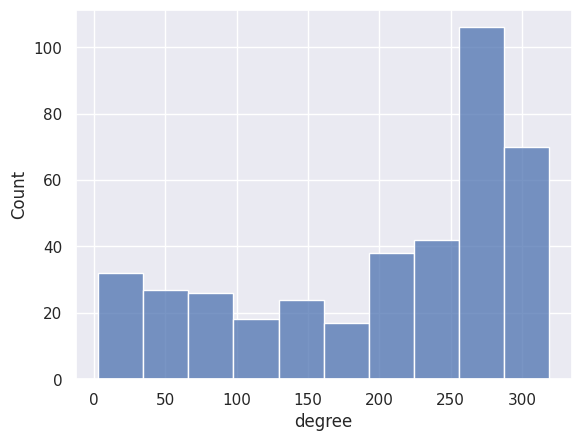

In [41]:
data_prova = gt_data(g_prova)
degrees = []
for v in g_prova.all_vertices():
    degrees.append(v.total_degree())
data_prova['degree'] = degrees
sns.histplot(data_prova['degree'])
data_prova['degree'].describe()

In [42]:
GRAFO_SFPD_PROVA_DIR = SAMPLE_400_DIR / 'SFPD_grafo_prova.net.gz'

In [43]:
# Método que aproxima e afasta vértices dependendo se estão ou não conectados, respectivamente
g_prova_SFDP = gt_load(GRAFO_PROVA_DIR)
g_prova_SFDP = gt_clean(g_prova_SFDP)
m = gt_draw.sfdp_layout(g_prova_SFDP)
gt_move(g_prova_SFDP, m)
gt_save(g_prova_SFDP, GRAFO_SFPD_PROVA_DIR)

In [44]:
# r = netpixi.render('./sample400/SFPD_grafo_prova.net.gz', infinite=True)

In [45]:
matrix = spectral.adjacency(g_prova_SFDP)

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c_prova = algorithm.get_coreness()

g_prova_SFDP.add_vp('coreness')

In [46]:
df['c_prova'] = df.index.map(c_prova.get)

In [47]:
# for i, coreness in c_prova.items():
#     v = g_prova_SFDP.get_vertex_by_index(i)
#     v['coreness'] = float(coreness)

# for v in g_prova_SFDP.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

## Criando DataFrames dos candidatos mais centrais

### Para rede de questionário

Separando centro de periferia

<AxesSubplot: ylabel='Count'>

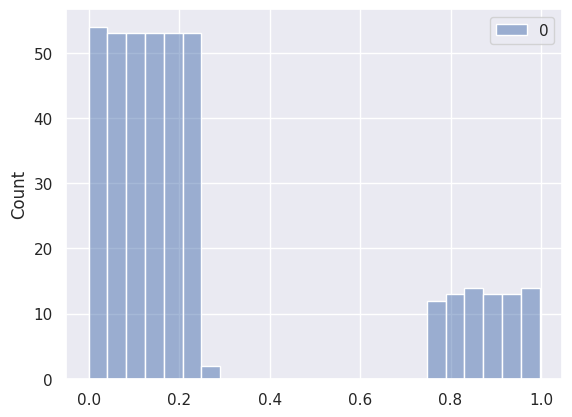

In [48]:
sns.histplot(c_quest.values())

In [49]:
thresh_centralidade_quest = 0.6

In [50]:
candidatos_centrais_quest = list()
for vertex_id in c_quest:
    if c_quest[vertex_id] > thresh_centralidade_quest:
        candidatos_centrais_quest.append(vertex_id)

In [51]:
df_centrais_quest = df.iloc[candidatos_centrais_quest]

### Para rede de Prova

<AxesSubplot: ylabel='Count'>

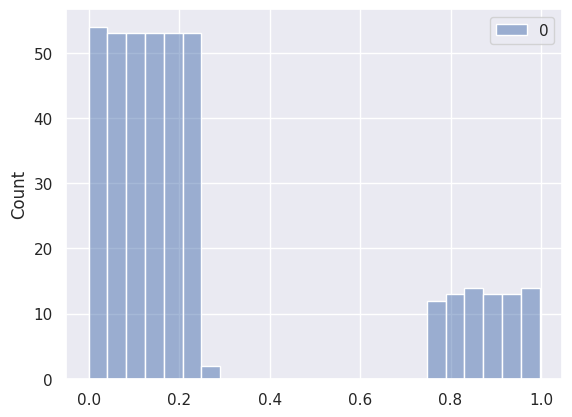

In [52]:
sns.histplot(c_prova.values())

In [53]:
thresh_centralidade_prova = 0.6

In [54]:
candidatos_centrais_prova = list()
for vertex_id in c_prova:
    if c_prova[vertex_id] > thresh_centralidade_prova:
        candidatos_centrais_prova.append(vertex_id)

In [55]:
df_centrais_prova = df.iloc[candidatos_centrais_prova]

In [56]:
df_centrais_prova.head()

,index,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,Q001,Q002,Q005,Q006,Q007,Q008,...,Respostas Questionario,Acertos Totias,Questoes Especificas,Questoes Gerais,Gabarito Especificas,Gabarito Gerais,Acertos Gerais,Acertos Especificas,c_quest,c_prova
0,1385728,210053015811,3,F,G,G,2.0,N,B,D,...,BGGNBDDBABBBBBBCCD,96,DABECAEABADCAECAEDEBBAEABDABCBDCCECDDDCADCACDC...,DAEABABDACCBEABDADBBDDEBBAACDCDCBBEACAAEBBABAA...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,48.0,48.0,0.014063,0.859375
4,1288196,210052768440,5,F,E,B,7.0,G,A,B,...,EEBGABDBBBCAAAABEB,40,BBDBECCABCDBACCDBBBEDAEBEEADBAEBDECCBDDBEABBAB...,DBAABAABDABAEEACBADABAEDBBAAEDDABCDADABCCAAADA...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,15.0,25.0,0.017969,0.834375
6,2290564,210051372886,1,F,E,E,4.0,D,A,C,...,DEEDACDAABBBBBACDB,49,ABACAAECABDBDCCBBCCBAAEADEADBDEEAECCCDABDADEEC...,DCAACCADADDDBABCDCBDAAECDBACDCDCBCCDDCAABEADBA...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,26.0,23.0,0.027344,0.912500
9,1375946,210054129416,3,M,D,E,4.0,F,A,C,...,DDEFACECABBBBBABEC,75,DBBCBDDBBCDCAEBCECABBAAADBABDBDDBEDEDDBDDCDCAC...,DEBACAABACCCEABDADDEDBCBDAEDACDCBBEBDBAAEEABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,41.0,34.0,0.070312,0.806250
12,81452,210053842564,1,F,E,E,2.0,B,A,B,...,BEEBABCAABBBABABCA,66,BDCBCAECBBCBECCAACBDBCEBDAABBCBBCEDBADCDAABCCB...,DEBBCCBDACBBEAADCAECCAEDDACEDCBCACEABDAEABABAD...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,32.0,34.0,0.058594,0.856250


In [57]:
df_centrais_quest

,index,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,Q001,Q002,Q005,Q006,Q007,Q008,...,Respostas Questionario,Acertos Totias,Questoes Especificas,Questoes Gerais,Gabarito Especificas,Gabarito Gerais,Acertos Gerais,Acertos Especificas,c_quest,c_prova
49,1528233,210053805767,10,F,C,B,2.0,C,A,B,...,BCBCABCBABAAABAACC,80,BDEEDAECBDCBEDEABEEBAEAABCADCEDEEEEBABADEAAADC...,EEBADCADAECBEBBEEECDBDADBBACDDECBBEEEEAEBBAAAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,38.0,42.0,0.918750,0.144531
58,1777517,210052753065,3,M,C,C,2.0,B,A,C,...,BCCBACCAABBBAAABCA,66,DBCCBABEDAECDDBADCEBCAEBBDCCBABEAEC*ECDBEABDCC...,DBEBEDBBACBCEABADCABDDDCDEADDDACACEADABEAEABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,32.0,34.0,0.975000,0.181250
62,1560309,210054435854,3,F,C,G,3.0,C,A,B,...,CCGCABCAABABAAABCA,44,BEEBABCABABCEC.CBAADBAAACDCCDBEDAEBCCEBEAABEEC...,DEEACBBDACBBEADEEABADDEDDEADDCACBCDAEEBACBABDA...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,27.0,17.0,0.968750,0.200781
77,597497,210052833780,3,M,E,E,2.0,B,A,B,...,BEEBABBBBBAAAAABCA,50,BADCBCBACECCDBDDBCABDBDBBADBBACEBECCABCCDBBDDB...,DADACEBCAEBAEABDEBAABCCCBBABCBBAABECEADEBAABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,27.0,23.0,0.984375,0.225781
82,1266144,210053590886,7,M,E,F,2.0,D,A,B,...,BEFDABBAABBAAAABCB,82,CDCDBADEBEBBADBAECEBBAEABACDDCCBCECBBCCBAAAEAC...,EAEACABCACBECBBEAABEBDDCDABADBDCCBBDEAAABEABAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,42.0,40.0,0.956250,0.211719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,1900315,210053836013,3,F,D,E,4.0,C,A,B,...,DDECABCABBAAAAABCA,47,CCACBACEDADAEBBABBABAAAACACDEECDBEEDABCDDBBBAE...,DEDBACDDAABEBAACCDDADADABBAADDBCADAEDBBDBBBBAE...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,21.0,26.0,0.896875,0.037500
330,2829310,210054423623,17,F,B,C,5.0,B,A,D,...,EBCBADDBABBBABACBB,53,ADEDBAEDBADBBCEDBEEBEEEEBECCABEBBECCBDCEAEACAB...,EDDACDBEEBABCADDBDCAEADCBAEADDDACCBEEAAABEBEAB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,30.0,23.0,0.893750,0.064844
339,805565,210053546624,6,F,A,E,4.0,B,A,B,...,DAEBABCAABAAAAABEA,38,AEDABAEDAEDBDACBCDACADBCEACCBEBBEEDEABDBDAEEDC...,EEBBADDCAEBECBDCDDAABDCCBBAECBAEBCBAECBDCEABCB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,18.0,20.0,0.943750,0.072656
347,1697108,210052531518,3,M,G,G,3.0,P,B,E,...,CGGPBEDCABBBBBBBDD,114,DDCCBADAEEBBBEBAEDEBBAEABCABCADEBBECACABEBACBD...,DEDADCBAACDBEADCAADADDADBABDDDACBBDAEAAABCABDB...,DDCEBADCBEBBADBAEDEBBAEABDABCEDEBEEBBCABEDDCBC...,DCEADABDACDCEABDADBEDDEBBACCDDDCBBBBEAAEBCABAB...,46.0,68.0,0.912500,0.060156


## Exportando arquivos

In [58]:
processed_dir = DATA_DIR / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)

In [59]:
processed_file_path_centrais = processed_dir / 'candidatos_centrais.pkl'

In [60]:
with open(processed_file_path_centrais, 'wb') as file:
    pickle.dump([df_centrais_prova, df_centrais_quest, df], file)